In [1]:
%load_ext nb_black
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [3]:
from xplainet.input_utils import preproc_dataset
from xplainet.model import build_model
from xplainet.random_utils import setup_seed, SEED
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

from zipfile import ZipFile

<IPython.core.display.Javascript object>

In [4]:
setup_seed()

<IPython.core.display.Javascript object>

In [5]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [6]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

## Bank marketing : loading data

In [7]:
dataset_name = "kaggle-house-prices"
out = Path(os.getcwd() + "/data/" + dataset_name + "-train.csv")

target = "SalePrice"
to_remove = []
train = pd.read_csv(out, sep=",", low_memory=False)

<IPython.core.display.Javascript object>

In [8]:
!ls data

census-income.csv	forest-cover-type.zip	       wine-quality.csv
census-income_test.csv	kaggle-house-prices-test.csv
forest-cover-type.csv	kaggle-house-prices-train.csv


<IPython.core.display.Javascript object>

In [9]:
train.shape

(1460, 81)

<IPython.core.display.Javascript object>

In [10]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

<IPython.core.display.Javascript object>

In [11]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_valid_index, test_index = next(
        ShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0])
        )
    )
    train_index, valid_index = next(
        ShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            train_valid_index
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"
    train["Set"][test_index] = "test"
    # train.to_csv((out.parent / "train_bench.csv").as_posix(), index=False)

Building tailored column


/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

<IPython.core.display.Javascript object>

In [12]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [13]:
input_train, params = preproc_dataset(train.loc[train_indices], target, ["Set"])
params

{'constant_cols': [],
 'bool_cols': ['Alley', 'Street', 'CentralAir', 'Utilities'],
 'num_cols': ['GarageYrBlt',
  '1stFlrSF',
  'LotFrontage',
  'GrLivArea',
  'ScreenPorch',
  'TotalBsmtSF',
  'BsmtFinSF1',
  'Id',
  'BsmtUnfSF',
  'GarageArea',
  'YearBuilt',
  'BsmtFinSF2',
  'WoodDeckSF',
  'MasVnrArea',
  'LotArea',
  'EnclosedPorch',
  '2ndFlrSF',
  'YearRemodAdd',
  'OpenPorchSF'],
 'cat_cols': ['HeatingQC',
  'Condition2',
  'MiscFeature',
  'RoofStyle',
  'BsmtCond',
  'Foundation',
  'PavedDrive',
  'LandSlope',
  'MiscVal',
  'LotConfig',
  'GarageCond',
  'ExterCond',
  'SaleType',
  'Fence',
  'KitchenQual',
  'SaleCondition',
  'Fireplaces',
  '3SsnPorch',
  'GarageFinish',
  'PoolQC',
  'RoofMatl',
  'BsmtHalfBath',
  'GarageType',
  'Heating',
  'BsmtFullBath',
  'Electrical',
  'MSSubClass',
  'Exterior1st',
  'ExterQual',
  'LandContour',
  'TotRmsAbvGrd',
  'LotShape',
  'BsmtExposure',
  'BedroomAbvGr',
  'OverallQual',
  'OverallCond',
  'BsmtFinType2',
  'Neighbo

<IPython.core.display.Javascript object>

In [14]:
len(train_indices)

1219

<IPython.core.display.Javascript object>

In [15]:
input_valid, _ = preproc_dataset(train.loc[valid_indices], target, ["Set"], params)
input_test, _ = preproc_dataset(train.loc[test_indices], target, ["Set"], params)

<IPython.core.display.Javascript object>

In [16]:
target_encoder = StandardScaler()

<IPython.core.display.Javascript object>

In [17]:
target_encoder.fit(train[target].values.reshape(-1, 1))
y_train = target_encoder.transform(train[target].values[train_indices].reshape(-1, 1))
y_valid = target_encoder.transform(train[target].values[valid_indices].reshape(-1, 1))
y_test = target_encoder.transform(train[target].values[test_indices].reshape(-1, 1))

<IPython.core.display.Javascript object>

In [18]:
params

{'constant_cols': [],
 'bool_cols': ['Alley', 'Street', 'CentralAir', 'Utilities'],
 'num_cols': ['GarageYrBlt',
  '1stFlrSF',
  'LotFrontage',
  'GrLivArea',
  'ScreenPorch',
  'TotalBsmtSF',
  'BsmtFinSF1',
  'Id',
  'BsmtUnfSF',
  'GarageArea',
  'YearBuilt',
  'BsmtFinSF2',
  'WoodDeckSF',
  'MasVnrArea',
  'LotArea',
  'EnclosedPorch',
  '2ndFlrSF',
  'YearRemodAdd',
  'OpenPorchSF'],
 'cat_cols': ['HeatingQC',
  'Condition2',
  'MiscFeature',
  'RoofStyle',
  'BsmtCond',
  'Foundation',
  'PavedDrive',
  'LandSlope',
  'MiscVal',
  'LotConfig',
  'GarageCond',
  'ExterCond',
  'SaleType',
  'Fence',
  'KitchenQual',
  'SaleCondition',
  'Fireplaces',
  '3SsnPorch',
  'GarageFinish',
  'PoolQC',
  'RoofMatl',
  'BsmtHalfBath',
  'GarageType',
  'Heating',
  'BsmtFullBath',
  'Electrical',
  'MSSubClass',
  'Exterior1st',
  'ExterQual',
  'LandContour',
  'TotRmsAbvGrd',
  'LotShape',
  'BsmtExposure',
  'BedroomAbvGr',
  'OverallQual',
  'OverallCond',
  'BsmtFinType2',
  'Neighbo

<IPython.core.display.Javascript object>

In [19]:
model = build_model(
    params,
    lconv_dim=[4],
    lconv_num_dim=[8],
    emb_size=16,
    # For this problem, we need "tanh" as first layer, or else to standard scale the data beforehand
    activation_num_first_layer="tanh",
    output_activation=None,
    output_dim=1,  # np.unique(y_train).shape[0],
)

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.3.0 and trying to load a custom op (custom_ops/activations/_activation_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are

<IPython.core.display.Javascript object>

In [20]:
model.summary()

Model: "explainable_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_num (InputLayer)          [(None, 19)]         0                                            
__________________________________________________________________________________________________
input_cat (InputLayer)          [(None, 57)]         0                                            
__________________________________________________________________________________________________
reshape_num_input (Reshape)     (None, 19, 1)        0           input_num[0][0]                  
__________________________________________________________________________________________________
large_emb (Embedding)           (None, 57, 16)       432         input_cat[0][0]                  
__________________________________________________________________________________

<IPython.core.display.Javascript object>

In [21]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

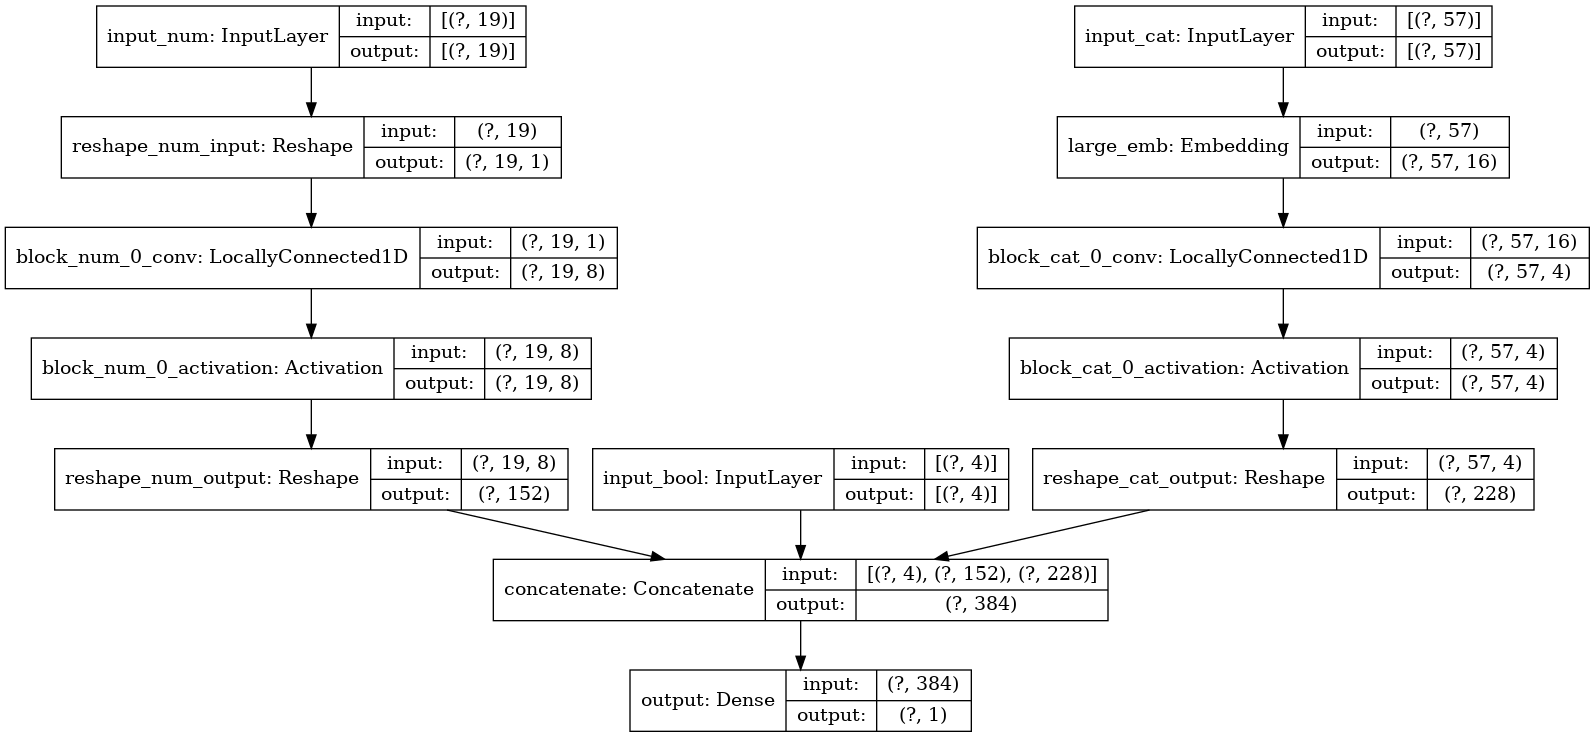

<IPython.core.display.Javascript object>

In [22]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [23]:
y_train.shape

(1219, 1)

<IPython.core.display.Javascript object>

In [24]:
counts = np.unique(y_train, return_counts=True)[1]
counts = counts.sum() / counts

<IPython.core.display.Javascript object>

In [25]:
%%time
history = model.fit(
    input_train,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=50, verbose=1)],
    #class_weight=None#class_weight
)

Epoch 1/2000
2/2 - 0s - loss: 0.9952 - val_loss: 1.0720
Epoch 2/2000
2/2 - 0s - loss: 0.9901 - val_loss: 1.0669
Epoch 3/2000
2/2 - 0s - loss: 0.9854 - val_loss: 1.0705
Epoch 4/2000
2/2 - 0s - loss: 0.9890 - val_loss: 1.0689
Epoch 5/2000
2/2 - 0s - loss: 0.9876 - val_loss: 1.0669
Epoch 6/2000
2/2 - 0s - loss: 0.9857 - val_loss: 1.0675
Epoch 7/2000
2/2 - 0s - loss: 0.9862 - val_loss: 1.0647
Epoch 8/2000
2/2 - 0s - loss: 0.9837 - val_loss: 1.0616
Epoch 9/2000
2/2 - 0s - loss: 0.9809 - val_loss: 1.0629
Epoch 10/2000
2/2 - 0s - loss: 0.9820 - val_loss: 1.0593
Epoch 11/2000
2/2 - 0s - loss: 0.9787 - val_loss: 1.0554
Epoch 12/2000
2/2 - 0s - loss: 0.9754 - val_loss: 1.0571
Epoch 13/2000
2/2 - 0s - loss: 0.9768 - val_loss: 1.0529
Epoch 14/2000
2/2 - 0s - loss: 0.9730 - val_loss: 1.0485
Epoch 15/2000
2/2 - 0s - loss: 0.9690 - val_loss: 1.0505
Epoch 16/2000
2/2 - 0s - loss: 0.9708 - val_loss: 1.0456
Epoch 17/2000
2/2 - 0s - loss: 0.9665 - val_loss: 1.0407
Epoch 18/2000
2/2 - 0s - loss: 0.9620 - 

2/2 - 0s - loss: 0.4324 - val_loss: 0.4903
Epoch 145/2000
2/2 - 0s - loss: 0.4373 - val_loss: 0.4803
Epoch 146/2000
2/2 - 0s - loss: 0.4271 - val_loss: 0.4703
Epoch 147/2000
2/2 - 0s - loss: 0.4168 - val_loss: 0.4753
Epoch 148/2000
2/2 - 0s - loss: 0.4218 - val_loss: 0.4656
Epoch 149/2000
2/2 - 0s - loss: 0.4117 - val_loss: 0.4561
Epoch 150/2000
2/2 - 0s - loss: 0.4017 - val_loss: 0.4609
Epoch 151/2000
2/2 - 0s - loss: 0.4066 - val_loss: 0.4517
Epoch 152/2000
2/2 - 0s - loss: 0.3968 - val_loss: 0.4425
Epoch 153/2000
2/2 - 0s - loss: 0.3871 - val_loss: 0.4471
Epoch 154/2000
2/2 - 0s - loss: 0.3919 - val_loss: 0.4381
Epoch 155/2000
2/2 - 0s - loss: 0.3822 - val_loss: 0.4294
Epoch 156/2000
2/2 - 0s - loss: 0.3731 - val_loss: 0.4338
Epoch 157/2000
2/2 - 0s - loss: 0.3778 - val_loss: 0.4257
Epoch 158/2000
2/2 - 0s - loss: 0.3686 - val_loss: 0.4179
Epoch 159/2000
2/2 - 0s - loss: 0.3599 - val_loss: 0.4218
Epoch 160/2000
2/2 - 0s - loss: 0.3644 - val_loss: 0.4143
Epoch 161/2000
2/2 - 0s - los

Epoch 286/2000
2/2 - 0s - loss: 0.1563 - val_loss: 0.3125
Epoch 287/2000
2/2 - 0s - loss: 0.1553 - val_loss: 0.3126
Epoch 288/2000
2/2 - 0s - loss: 0.1543 - val_loss: 0.3125
Epoch 289/2000
2/2 - 0s - loss: 0.1548 - val_loss: 0.3125
Epoch 290/2000
2/2 - 0s - loss: 0.1537 - val_loss: 0.3125
Epoch 291/2000
2/2 - 0s - loss: 0.1527 - val_loss: 0.3126
Epoch 292/2000
2/2 - 0s - loss: 0.1532 - val_loss: 0.3127
Epoch 293/2000
2/2 - 0s - loss: 0.1522 - val_loss: 0.3127
Epoch 294/2000
2/2 - 0s - loss: 0.1512 - val_loss: 0.3125
Epoch 295/2000
2/2 - 0s - loss: 0.1517 - val_loss: 0.3124
Epoch 296/2000
2/2 - 0s - loss: 0.1509 - val_loss: 0.3124
Epoch 297/2000
2/2 - 0s - loss: 0.1500 - val_loss: 0.3124
Epoch 298/2000
2/2 - 0s - loss: 0.1504 - val_loss: 0.3124
Epoch 299/2000
2/2 - 0s - loss: 0.1494 - val_loss: 0.3124
Epoch 300/2000
2/2 - 0s - loss: 0.1485 - val_loss: 0.3124
Epoch 301/2000
2/2 - 0s - loss: 0.1490 - val_loss: 0.3123
Epoch 302/2000
2/2 - 0s - loss: 0.1481 - val_loss: 0.3121
Epoch 303/2000

<IPython.core.display.Javascript object>

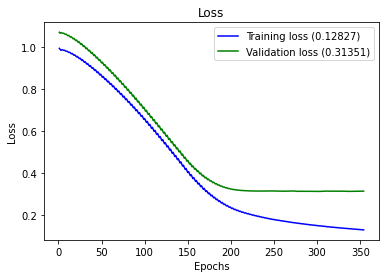

<IPython.core.display.Javascript object>

In [26]:
plot_history(history)

In [27]:
model_auc = mean_absolute_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_valid)).reshape(-1),
    y_true=train[target].values[valid_indices],
)
model_auc

21797.53396381579

<IPython.core.display.Javascript object>

In [28]:
model_auc = mean_squared_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_valid)).reshape(-1),
    y_true=train[target].values[valid_indices],
)
model_auc

1977252545.9905922

<IPython.core.display.Javascript object>

In [29]:
model_auc = mean_absolute_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_test)).reshape(-1),
    y_true=train[target].values[test_indices],
)
model_auc

20278.334011130137

<IPython.core.display.Javascript object>

In [30]:
model_auc = mean_squared_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_test)).reshape(-1),
    y_true=train[target].values[test_indices],
)
model_auc

1481659674.2370112

<IPython.core.display.Javascript object>

In [31]:
from xplainet.model import predict, encode

<IPython.core.display.Javascript object>

In [32]:
probs, explanations = predict(model, input_test)

<IPython.core.display.Javascript object>

In [33]:
probs, encoded_output = encode(model, input_test)

<IPython.core.display.Javascript object>

In [34]:
y_test.shape

(146, 1)

<IPython.core.display.Javascript object>

In [35]:
encoded_output.shape

(146, 384)

<IPython.core.display.Javascript object>

In [36]:
explanations.shape

(146, 80)

<IPython.core.display.Javascript object>

In [37]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    selection = np.argsort(-np.absolute(importances))[:10]
    # indexes = np.argsort(importances)
    performance = importances[selection]
    #     print(performance.shape)512, 256, 128, 64, 32, 1
    y_pos = np.arange(performance.shape[0])

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[selection])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

<IPython.core.display.Javascript object>

In [38]:
all_cols = np.array(params["bool_cols"] + params["num_cols"] + params["cat_cols"])
all_cols

array(['Alley', 'Street', 'CentralAir', 'Utilities', 'GarageYrBlt',
       '1stFlrSF', 'LotFrontage', 'GrLivArea', 'ScreenPorch',
       'TotalBsmtSF', 'BsmtFinSF1', 'Id', 'BsmtUnfSF', 'GarageArea',
       'YearBuilt', 'BsmtFinSF2', 'WoodDeckSF', 'MasVnrArea', 'LotArea',
       'EnclosedPorch', '2ndFlrSF', 'YearRemodAdd', 'OpenPorchSF',
       'HeatingQC', 'Condition2', 'MiscFeature', 'RoofStyle', 'BsmtCond',
       'Foundation', 'PavedDrive', 'LandSlope', 'MiscVal', 'LotConfig',
       'GarageCond', 'ExterCond', 'SaleType', 'Fence', 'KitchenQual',
       'SaleCondition', 'Fireplaces', '3SsnPorch', 'GarageFinish',
       'PoolQC', 'RoofMatl', 'BsmtHalfBath', 'GarageType', 'Heating',
       'BsmtFullBath', 'Electrical', 'MSSubClass', 'Exterior1st',
       'ExterQual', 'LandContour', 'TotRmsAbvGrd', 'LotShape',
       'BsmtExposure', 'BedroomAbvGr', 'OverallQual', 'OverallCond',
       'BsmtFinType2', 'Neighborhood', 'FullBath', 'Functional',
       'FireplaceQu', 'MasVnrType', 'HalfBath

<IPython.core.display.Javascript object>

## Explain global

In [39]:
# Looks like this is broken for now.

<IPython.core.display.Javascript object>

In [40]:
probs_train, explanations_train = predict(model, input_train)

<IPython.core.display.Javascript object>

In [41]:
global_explain = np.abs(explanations_train).sum(axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

In [42]:
global_explain

array([0.01215346, 0.01259931, 0.01232962, 0.01247911, 0.01251009,
       0.01259026, 0.01250862, 0.01258593, 0.01249374, 0.01257558,
       0.01252444, 0.01247921, 0.0125008 , 0.0125607 , 0.0124805 ,
       0.01247848, 0.01250196, 0.01253927, 0.01253721, 0.01247924,
       0.01254214, 0.01256049, 0.01251706, 0.01246301, 0.01246805,
       0.01246541, 0.01255347, 0.0124383 , 0.01249522, 0.01243638,
       0.01254407, 0.0124729 , 0.01250988, 0.01246   , 0.01247715,
       0.01254957, 0.01247233, 0.01256865, 0.0124852 , 0.01253109,
       0.01250283, 0.01250565, 0.01249047, 0.01249789, 0.01244909,
       0.01245513, 0.01248395, 0.01252677, 0.01246678, 0.01246023,
       0.0125155 , 0.01259258, 0.01251211, 0.01258737, 0.01252522,
       0.0126105 , 0.01253636, 0.01262202, 0.01245211, 0.01246091,
       0.0126368 , 0.01253023, 0.01242545, 0.01258366, 0.01250471,
       0.0125318 , 0.01246474, 0.01247848, 0.01255076, 0.01250262,
       0.0126519 , 0.0123129 , 0.01240089, 0.01247945, 0.01248

<IPython.core.display.Javascript object>

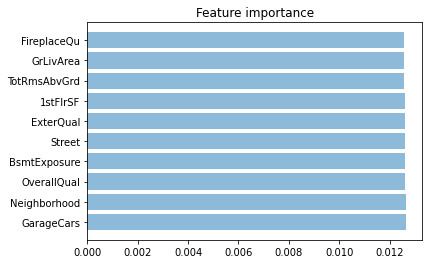

<IPython.core.display.Javascript object>

In [43]:
explain_plot(global_explain, all_cols)

## Explain local

In [44]:
# Looks like this is broken for now.

<IPython.core.display.Javascript object>

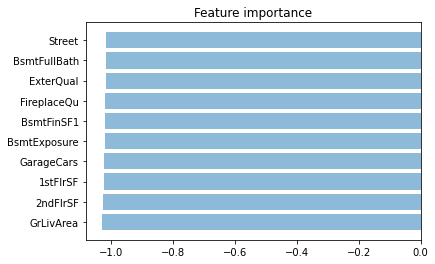

-0.6638028621673584


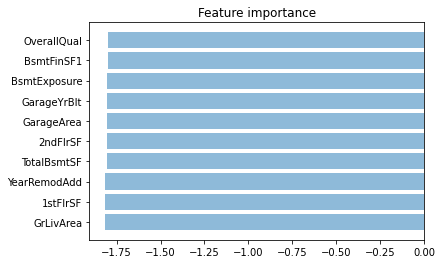

-1.6289162635803223


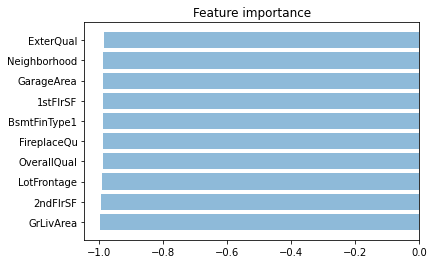

-0.6235273480415344


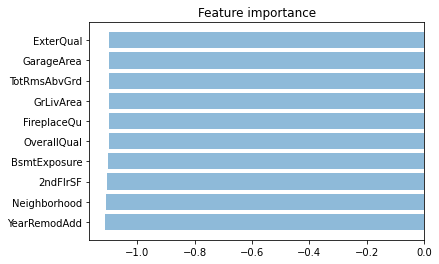

-0.7696265578269958


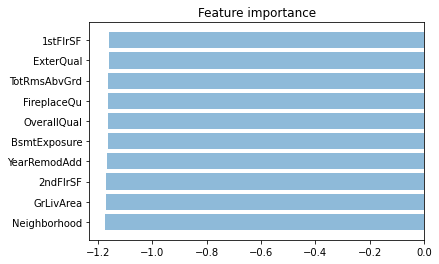

-0.851474940776825


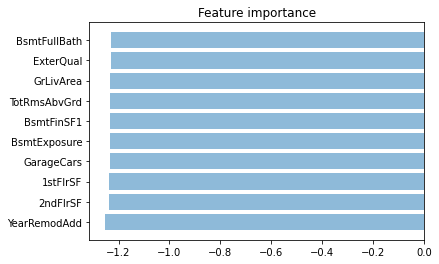

-0.9393419623374939


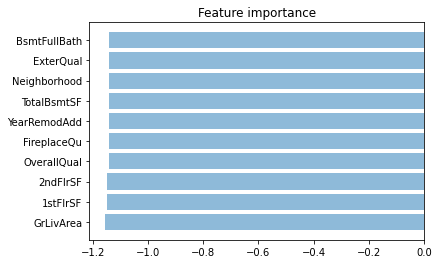

-0.825083315372467


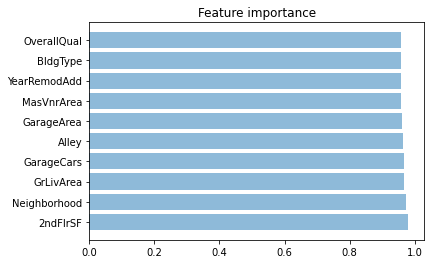

1.8057377338409424


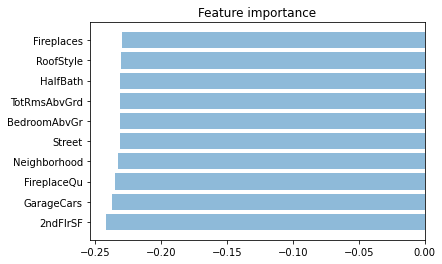

0.3722544312477112


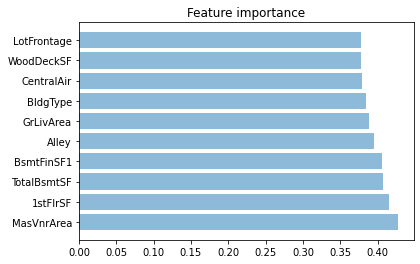

1.1210969686508179


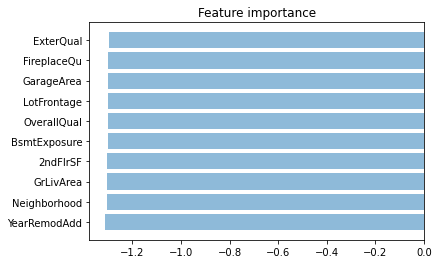

-1.0212703943252563


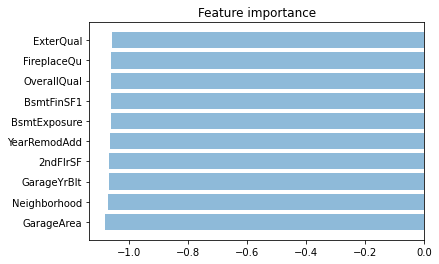

-0.7191378474235535


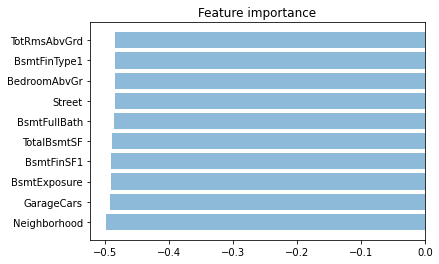

0.03590421751141548


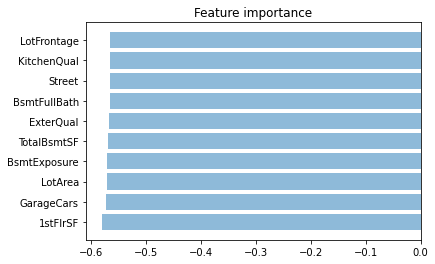

-0.07192059606313705


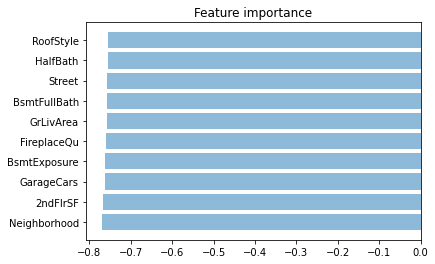

-0.3259488046169281


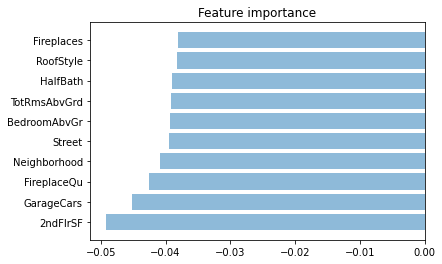

0.6218269467353821


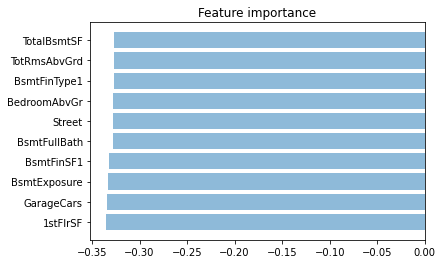

0.24499619007110596


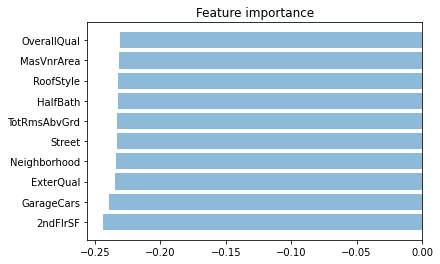

0.36947116255760193


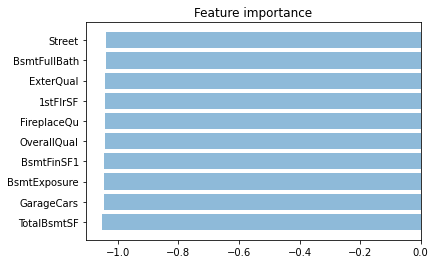

-0.6966938376426697


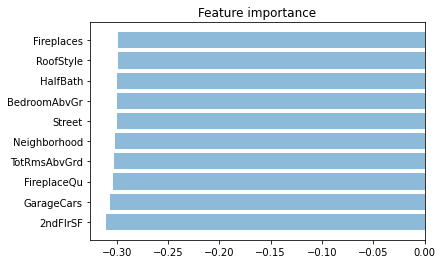

0.28163987398147583


<IPython.core.display.Javascript object>

In [45]:
for i in range(20):
    explain_plot(explanations[i], all_cols)
    print(probs[i].item())

In [46]:
from sklearn.metrics import confusion_matrix

<IPython.core.display.Javascript object>

In [47]:
probs_test, explanations_train = predict(model, input_test)

<IPython.core.display.Javascript object>

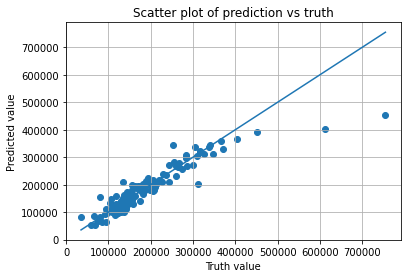

<IPython.core.display.Javascript object>

In [48]:
# plt.barh(y_pos, performance, align="center", alpha=0.5)
# plt.yticks(y_pos, columns[selection])
plt.ylabel("Predicted value")
plt.xlabel("Truth value")

plt.title("Scatter plot of prediction vs truth")
plt.scatter(
    train[target].values[test_indices],
    target_encoder.inverse_transform(probs_test),
)
plt.plot(
    [
        np.min(train[target].values[test_indices]),
        np.max(train[target].values[test_indices]),
    ],
    [
        np.min(train[target].values[test_indices]),
        np.max(train[target].values[test_indices]),
    ],
)
plt.grid(True)
plt.show()

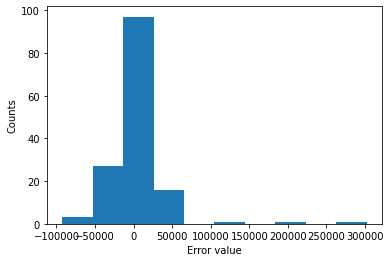

<IPython.core.display.Javascript object>

In [49]:
plt.hist(
    train[target].values[test_indices].reshape(-1)
    - target_encoder.inverse_transform(probs_test).reshape(-1),
)
plt.xlabel("Error value")
plt.ylabel("Counts")
plt.show()

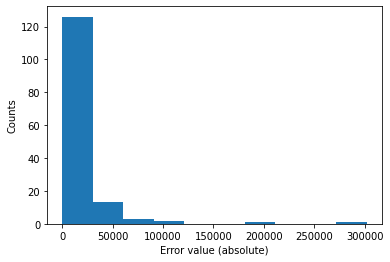

<IPython.core.display.Javascript object>

In [50]:
plt.hist(
    np.abs(
        train[target].values[test_indices].reshape(-1)
        - target_encoder.inverse_transform(probs_test).reshape(-1),
    )
)
plt.xlabel("Error value (absolute)")
plt.ylabel("Counts")
plt.show()

In [51]:
out = Path(os.getcwd() + "/data/" + dataset_name + "-test.csv")

<IPython.core.display.Javascript object>

In [52]:
kaggle_test = train = pd.read_csv(out, sep=",", low_memory=False)

<IPython.core.display.Javascript object>

In [53]:
input_kaggle, _ = preproc_dataset(kaggle_test, target, ["Set"], params)

<IPython.core.display.Javascript object>

In [54]:
probs_kaggle, _ = predict(model, input_kaggle)

<IPython.core.display.Javascript object>

In [55]:
probs_kaggle = target_encoder.inverse_transform(probs_kaggle)

<IPython.core.display.Javascript object>

In [56]:
probs_kaggle

array([[118826.086],
       [168432.67 ],
       [204974.73 ],
       ...,
       [191878.77 ],
       [119177.06 ],
       [225938.64 ]], dtype=float32)

<IPython.core.display.Javascript object>

In [57]:
test_df = kaggle_test[["Id"]]

<IPython.core.display.Javascript object>

In [58]:
test_df["SalePrice"] = probs_kaggle

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

In [59]:
test_df.to_csv("kaggle_submit.csv", index=False)

<IPython.core.display.Javascript object>

In [60]:
# Scores 0.18047 on kaggle
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard#score
# Should train with RMSLE ?
# from tensorflow.keras import backend as K

# def root_mean_squared_log_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(K.log(1+y_pred) - K.log(1+y_true))))

<IPython.core.display.Javascript object>